In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import datetime
import time
import sys
import os
import tables
import io
import gzip
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras import backend as K,objectives
from keras.optimizers import Adam
from keras.models import model_from_json
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import CSVLogger

pd.set_option('display.max_columns', None)

Using TensorFlow backend.


In [4]:
# Path to the Million Song Dataset subset (uncompressed) - change to the location on your laptop
# Cannot store this on github as it is too large
msd_subset_path = '../../MSD_data/MillionSongSubset/'

# Keep these - folders match the structure of the uncompressed file
msd_subset_data_path = os.path.join(msd_subset_path, 'data')
msd_subset_addf_path = os.path.join(msd_subset_path, 'AdditionalFiles')

*Use Rhythm Histogram and Statistical Spectrum Descriptor data from http://www.ifs.tuwien.ac.at/mir/audiofeatureextraction.html to attempt to predict hotness*

In [5]:
rh_hotness_clean = pd.read_pickle(msd_subset_path+'rh_and_hotness_clean.pkl')
ssd_hotness_clean = pd.read_pickle(msd_subset_path+'ssd_and_hotness_clean.pkl')

*Check for duplicate tracks*

In [6]:
assert (ssd_hotness_clean.groupby('song_id').count()['track_id'] > 1).sum() == 0 
assert (rh_hotness_clean.groupby('song_id').count()['track_id'] > 1).sum() == 0

In [52]:
# Outline taken from https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=True):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (width, height, depth)
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
    # if this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    return model

*Combine features into single dataset for training*

In [34]:
y = rh_hotness_clean.song_hotttnesss
x_rh = rh_hotness_clean.drop(['track_id', 'song_id', 'song_hotttnesss'], axis = 1)
x_ssd = ssd_hotness_clean.drop(['track_id', 'song_id', 'song_hotttnesss'], axis = 1)
x = np.concatenate((x_rh, x_ssd), axis = 1)
# df = ssd_hotness_clean # rh_hotness_clean
# x = df.drop(['track_id', 'song_id', 'song_hotttnesss'], axis = 1)

In [36]:
w_rh = 12 # 21 15
h_rh = 19 # 8  4
csv_logger = CSVLogger('history.log', separator=',', append=False)

x = MinMaxScaler().fit_transform(x)
(trainX, testX, trainY, testY) = train_test_split(x, y.values, test_size=0.25, random_state=109)


In [37]:
trainX = np.expand_dims(trainX.reshape(trainX.shape[0], w_rh, h_rh), axis = -1)
testX = np.expand_dims(testX.reshape(testX.shape[0], w_rh, h_rh), axis = -1)

In [38]:
K.clear_session()

model = create_cnn(w_rh, h_rh, 1, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt, metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 19, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 19, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 12, 19, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 19, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 9, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 9, 32)          4640      
_________________________________________________________________
activation_2 (Activation)    (None, 6, 9, 32)          0         
__________

In [39]:
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=100, batch_size=8,
                                 callbacks=[csv_logger]);

Train on 4236 samples, validate on 1412 samples
Epoch 1/100
4236/4236 [==============================] - 7s 2ms/step - loss: 11122137.0086 - acc: 0.2455 - val_loss: 11161730934.9169 - val_acc: 0.0000e+00
Epoch 2/100
4236/4236 [==============================] - 6s 2ms/step - loss: 59524.7981 - acc: 0.2524 - val_loss: 48981814.7880 - val_acc: 0.2585
Epoch 3/100
4236/4236 [==============================] - 6s 2ms/step - loss: 45537.0386 - acc: 0.2524 - val_loss: 10513515.1793 - val_acc: 0.2585
Epoch 4/100
4236/4236 [==============================] - 6s 2ms/step - loss: 66747.1027 - acc: 0.2524 - val_loss: 10075946.5765 - val_acc: 0.2585
Epoch 5/100
4236/4236 [==============================] - 6s 1ms/step - loss: 47350.7094 - acc: 0.2524 - val_loss: 10077985.6018 - val_acc: 0.2585
Epoch 6/100
4236/4236 [==============================] - 6s 1ms/step - loss: 39390.6199 - acc: 0.2524 - val_loss: 9463629.2063 - val_acc: 0.2585
Epoch 7/100
4236/4236 [==============================] - 6s 1ms/ste

Epoch 57/100
4236/4236 [==============================] - 6s 2ms/step - loss: 62546.7399 - acc: 0.2524 - val_loss: 6154441.7151 - val_acc: 0.2585
Epoch 58/100
4236/4236 [==============================] - 6s 2ms/step - loss: 41634.0523 - acc: 0.2524 - val_loss: 6169412.3637 - val_acc: 0.2585
Epoch 59/100
4236/4236 [==============================] - 6s 1ms/step - loss: 49469.7343 - acc: 0.2524 - val_loss: 6093748.8627 - val_acc: 0.2585
Epoch 60/100
4236/4236 [==============================] - 6s 2ms/step - loss: 49302.9886 - acc: 0.2524 - val_loss: 6162251.4707 - val_acc: 0.2585
Epoch 61/100
4236/4236 [==============================] - 6s 2ms/step - loss: 43140.5787 - acc: 0.2524 - val_loss: 6151303.0808 - val_acc: 0.2585
Epoch 62/100
4236/4236 [==============================] - 6s 2ms/step - loss: 58630.8238 - acc: 0.2524 - val_loss: 6157351.8649 - val_acc: 0.2585
Epoch 63/100
4236/4236 [==============================] - 6s 1ms/step - loss: 48900.5680 - acc: 0.2524 - val_loss: 6101059.7

In [40]:
model.save_weights("audio_model1.h5")
model_json = model.to_json()
with open("audio_model1.json", "w") as json_file:
    json_file.write(model_json)

Test loss: 6.16e+06
Test accuracy: 0.258


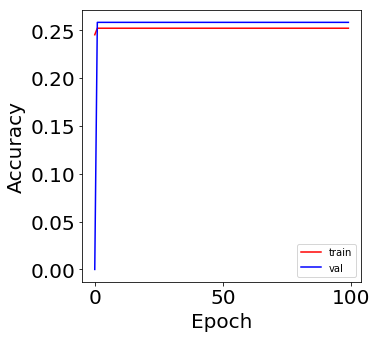

In [43]:
loss, accuracy  = model.evaluate(testX, testY, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot((history.history['acc']), 'r', label='train')
ax.plot((history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [45]:
y_pred = model.predict(np.expand_dims(x.reshape(x.shape[0], w_rh, h_rh), axis = -1))


In [46]:
print('Model test MSE: {}'.format(mean_squared_error(y_pred, y)))


Model test MSE: 0.16286570165047512


In [49]:
(y_pred > 0.1).sum()

0

*Not good - no hotness predicted*